<a href="https://colab.research.google.com/github/dgo95/TFG_IDENTIFICACION_AVES/blob/main/4.Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 5.8 MB 4.3 MB/s 
     |████████████████████████████████| 1.4 MB 67.1 MB/s 
     |████████████████████████████████| 462 kB 76.6 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvid

In [ ]:
from keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt #Dibujo
import numpy as np
import os
import pandas as pd
import seaborn as sns
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
import tensorflow.keras.activations as nn
import time as tempo


In [ ]:
def enHorasYMinutos(seg):
    horas = seg // 3600
    seg = seg - horas * 3600
    minutos = seg // 60
    seg = seg - minutos *60
    aux = str(int(horas))+" horas "+str(int(minutos))+" minutos y "+str(int(seg))+" segundos"
    return aux

In [ ]:
EPOCAS = 100
lr = 0.01
#cargar datos
train_images = []
train_labels = []
test_images = []
test_labels = []
# lectura de los datos

path = os.path.join('drive',"MyDrive","Colab Notebooks", "Cuaderno1")
entrenamientoPath=os.path.join(path,"DataSet","Espectrogramas", "train")
testPath = os.path.join(path,"DataSet","Espectrogramas", "test")
valPath = os.path.join(path,"DataSet","Espectrogramas", "val")
etiqueta = 0
leyenda = {}
IM_SIZE1 = (216, 216)
IM_SIZE = (216, 216,3)
BIRDS = []
BATCH_SIZE = 16
densenet121=(tf.keras.applications.densenet.DenseNet121,"densenet121.h5")
resnet50=(tf.keras.applications.resnet_v2.ResNet50V2,"resnet50.h5")
inceptionv3=(tf.keras.applications.inception_v3.InceptionV3,"inceptionv3tres.h5")
efficientnet=(tf.keras.applications.efficientnet.EfficientNetB3,"efficientnetB3.h5")
efficientnetB4=(tf.keras.applications.efficientnet.EfficientNetB4,"efficientnetB4.h5")

redNeuroanl , h5 =resnet50
h5 = os.path.join(path,h5)

In [ ]:
for nombre_directorio, dirs, ficheros in os.walk(entrenamientoPath):
  if nombre_directorio == entrenamientoPath:
    continue
  BIRDS.append(nombre_directorio.replace('drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/train/',""))
  leyenda[nombre_directorio.replace('drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/train/',"")] = etiqueta
  etiqueta = etiqueta + 1

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)
train_batches = train_datagen.flow_from_directory(
    entrenamientoPath,
    classes=BIRDS,
    target_size=IM_SIZE1,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(
    valPath,
    classes=BIRDS,
    target_size=IM_SIZE1,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(
    testPath,
    classes=BIRDS,
    target_size=IM_SIZE1,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 722 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 87 images belonging to 3 classes.


In [ ]:
net = redNeuroanl(
    include_top=False, weights="imagenet", input_tensor=None, input_shape=IM_SIZE
)
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(BIRDS), activation="softmax", name="softmax")(x)

model = Model(inputs=net.input, outputs=output_layer)
sgd = tf.keras.optimizers.SGD(
    learning_rate=lr,
    momentum=0.9)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

94683136/94668760 [==============================] - 4s 0us/step


In [ ]:
# Estimate class weights for unbalanced dataset
class_weights = class_weight.compute_class_weight("balanced", 
                                                  classes=np.unique(train_batches.classes), 
                                                  y=train_batches.classes
)
# Define callbacks
ModelCheck = ModelCheckpoint(
    filepath=h5,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

ReduceLR = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=5, min_lr=3e-4)

cuenta = 0
diccionario = {}
for i in class_weights:
  diccionario[cuenta] = i
  cuenta = cuenta +1

In [ ]:
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

In [ ]:
#model.load_weights(h5)
tic=tempo.time()

history = model.fit(
    train_batches,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps=STEP_SIZE_VALID,
    validation_data=valid_batches,
    epochs=EPOCAS,
    class_weight=diccionario,
    callbacks=[ModelCheck, ReduceLR],
)

print('Tiempo de procesamiento (secs): ', enHorasYMinutos(tempo.time()-tic))

Epoch 1/100
45/45 [==============================] - 419s 9s/step - loss: 2.0181 - accuracy: 0.6091 - val_loss: 1614.2126 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 8s 180ms/step - loss: 2.8751 - accuracy: 0.7025 - val_loss: 7606217.5000 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 8s 180ms/step - loss: 3.4410 - accuracy: 0.4575 - val_loss: 2300234.5000 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 9s 193ms/step - loss: 6.3053 - accuracy: 0.3952 - val_loss: 1209818880.0000 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 8s 181ms/step - loss: 4.1027 - accuracy: 0.3159 - val_loss: 128420.3125 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - 9s 208ms/step - loss: 3.7098 - accuracy: 0.4108 - val_loss: 64780.8984 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 7/100
45/45 [=============

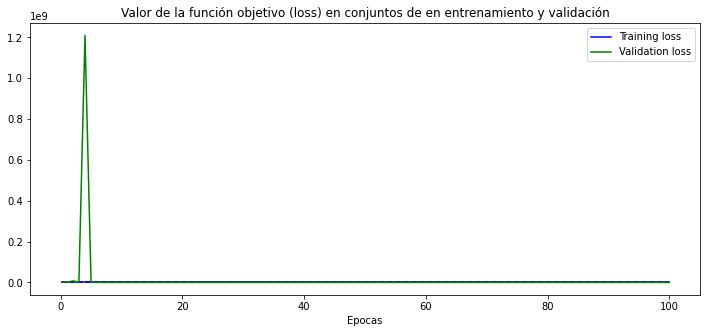

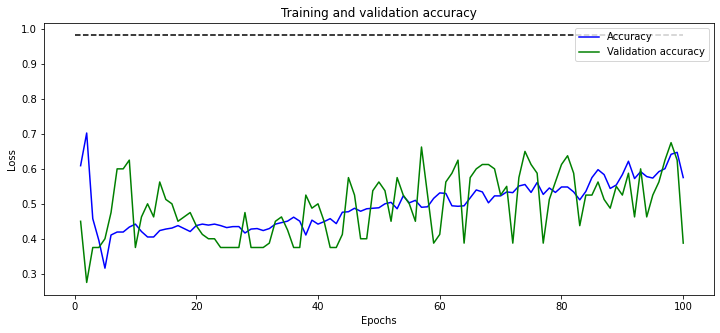

6/6 [==============================] - 54s 11s/step - loss: 9.3748 - accuracy: 0.7241
[9.374844551086426, 0.7241379022598267]


In [ ]:
history_dict = history.history
dictkeys=list(history_dict.keys())
# Mostrar resultados.

loss_values     = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.hlines(y=.078, xmin=0, xmax=EPOCAS, colors='k', linestyles='dashed')
plt.legend()

plt.show()


acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.hlines(y=.982, xmin=0, xmax=EPOCAS, colors='k', linestyles='dashed')
plt.legend()

plt.show()

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(h5)

results = model.evaluate(test_batches)
print(results)

Confusion Matrix


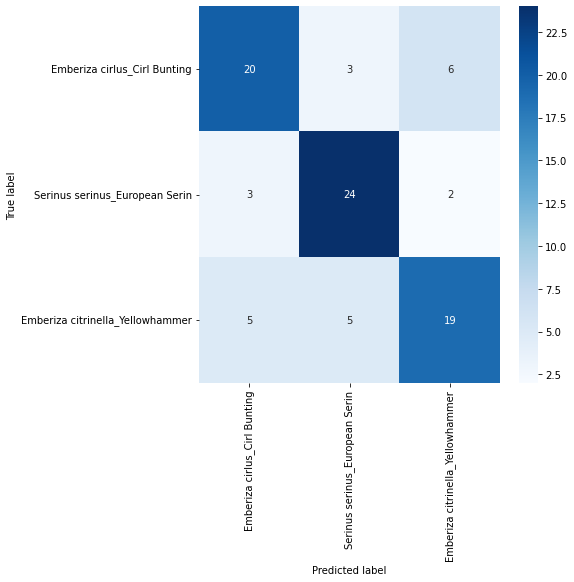

Classification Report
                                  precision    recall  f1-score   support

    Emberiza cirlus_Cirl Bunting       0.71      0.69      0.70        29
  Serinus serinus_European Serin       0.75      0.83      0.79        29
Emberiza citrinella_Yellowhammer       0.70      0.66      0.68        29

                        accuracy                           0.72        87
                       macro avg       0.72      0.72      0.72        87
                    weighted avg       0.72      0.72      0.72        87



In [ ]:
#Confution Matrix and Classification Report
target_names = list(train_batches.class_indices.keys())
Y_pred = model.predict(test_batches, len(test_batches.classes) // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_batches.classes, y_pred)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, xticklabels= target_names,yticklabels= target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Classification Report')

print(classification_report(test_batches.classes, y_pred, target_names=target_names))